
=== Distance-교육 1단계 강도 & 교육-임금 2단계 인과효과 (IV 비교) ===
Stage                Relation      Estimate   t-value  p-value       R²                         Notes
  1단계    Distance → Education -3.075499e-02 -2.873017 0.004084 0.270993                              
  2단계 Education → Wage (2SLS)  1.599645e+00  2.515358      NaN      NaN SE=0.636, 95% CI=(0.35, 2.85)
  2단계 Education → Wage (DRIV)  5.757510e-16       NaN      NaN      NaN                           ATE


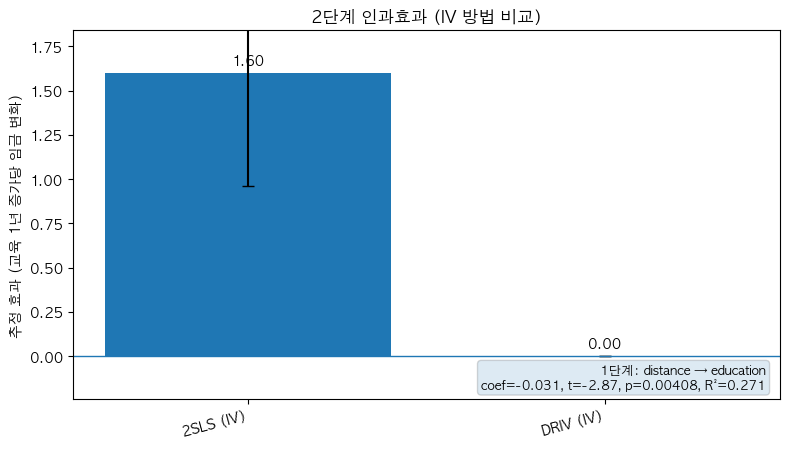

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
from sklearn.preprocessing import StandardScaler

# ===== econml 가용성 (버전별 안전) =====
try:
    from econml.iv.dr import DRIV
except Exception:
    DRIV = None
try:
    from econml.iv.dr import LinearDRIV
except Exception:
    LinearDRIV = None

# ===== 한글 폰트 설정 (OS별 시도) =====
def set_korean_font():
    try:
        import matplotlib
        if os.name == "nt":  # Windows
            matplotlib.rc("font", family="Malgun Gothic")
        else:
            # macOS, Linux 후보
            for fam in ["AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans CJK"]:
                try:
                    matplotlib.rc("font", family=fam)
                    break
                except Exception:
                    continue
        matplotlib.rcParams["axes.unicode_minus"] = False
    except Exception:
        pass

set_korean_font()

# ------------------------------------------------------------
# 1) 데이터 로드 
# ------------------------------------------------------------
DATA_URL = "https://vincentarelbundock.github.io/Rdatasets/csv/AER/CollegeDistance.csv"
LOCAL_PATH = "./CollegeDistance.csv"

def load_data():
    if os.path.exists(LOCAL_PATH):
        return pd.read_csv(LOCAL_PATH)
    try:
        return pd.read_csv(DATA_URL)
    except Exception:
        raise RuntimeError(
            "데이터 로딩 실패: 인터넷 또는 URL 문제가 있습니다.\n"
            "같은 폴더에 CollegeDistance.csv를 저장한 뒤 다시 실행하세요."
        )

raw = load_data()

# ------------------------------------------------------------
# 2) 전처리
# ------------------------------------------------------------
categorical_cols = ["gender", "ethnicity", "fcollege", "mcollege", "home", "urban", "income", "region"]
df = pd.get_dummies(raw, columns=categorical_cols, drop_first=True)

y_col, t_col, z_col = "wage", "education", "distance"
drop_cols = {"rownames", y_col, t_col, z_col, "tuition"}
X_cols = [c for c in df.columns if c not in drop_cols]

use_cols = [y_col, t_col, z_col] + X_cols
model_df = df[use_cols].apply(pd.to_numeric, errors="coerce").dropna().copy()

y = model_df[y_col].to_numpy(dtype=float)
T = model_df[t_col].to_numpy(dtype=float)
Z = model_df[z_col].to_numpy(dtype=float)
X = model_df[X_cols].astype(float)

# ------------------------------------------------------------
# 3) 1단계: Education ~ Distance + Controls
# ------------------------------------------------------------
fs_X = sm.add_constant(pd.concat([X, pd.Series(Z, name=z_col)], axis=1), has_constant="add").astype(float)
fs_mod = sm.OLS(T, fs_X).fit()

dist_coef = float(fs_mod.params[z_col])
dist_t = float(fs_mod.tvalues[z_col])
dist_p = float(fs_mod.pvalues[z_col])
dist_r2 = float(fs_mod.rsquared)

# ------------------------------------------------------------
# 4) 2단계: 2SLS (IV: distance)
# ------------------------------------------------------------
X_all = sm.add_constant(pd.concat([X, pd.Series(T, name=t_col)], axis=1), has_constant="add").astype(float)
Z_all = sm.add_constant(pd.concat([X, pd.Series(Z, name=z_col)], axis=1), has_constant="add").astype(float)

iv_res = IV2SLS(y, X_all, Z_all).fit()
iv_beta = float(iv_res.params[t_col])
iv_se = float(iv_res.bse[t_col])
iv_t = float(iv_res.tvalues[t_col])
iv_ci = (iv_beta - 1.96 * iv_se, iv_beta + 1.96 * iv_se)

# ------------------------------------------------------------
# 5) DRIV / LinearDRIV (IV)
# ------------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

driv_est, driv_tag, driv_ate = None, "", np.nan
if DRIV is not None:
    try:
        driv_est = DRIV(discrete_treatment=False, discrete_instrument=False, random_state=42)
        driv_est.fit(Y=y, T=T, Z=Z, X=X_scaled)
        driv_tag = "DRIV"
    except Exception:
        driv_est = None
if driv_est is None and LinearDRIV is not None:
    try:
        driv_est = LinearDRIV(discrete_treatment=False, discrete_instrument=False, random_state=42)
        driv_est.fit(Y=y, T=T, Z=Z, X=X_scaled)
        driv_tag = "LinearDRIV"
    except Exception:
        driv_est = None

if driv_est is not None:
    # 버전에 따라 ate(X=...) 또는 ate()
    try:
        driv_ate = float(driv_est.ate(X=X_scaled))
    except Exception:
        try:
            driv_ate = float(driv_est.ate())
        except Exception:
            driv_ate = np.nan

# ------------------------------------------------------------
# 6) 요약 테이블: 1단계 강도 + 2단계 인과효과(IV)
# ------------------------------------------------------------
summary_rows = [
    {"Stage":"1단계", "Relation":"Distance → Education", "Estimate":dist_coef,
     "t-value":dist_t, "p-value":dist_p, "R²":dist_r2, "Notes":""},
    {"Stage":"2단계", "Relation":"Education → Wage (2SLS)", "Estimate":iv_beta,
     "t-value":iv_t, "p-value":np.nan, "R²":np.nan, "Notes":f"SE={iv_se:.3f}, 95% CI=({iv_ci[0]:.2f}, {iv_ci[1]:.2f})"}
]
if not np.isnan(driv_ate):
    summary_rows.append({"Stage":"2단계", "Relation":f"Education → Wage ({driv_tag})",
                         "Estimate":driv_ate, "t-value":np.nan, "p-value":np.nan, "R²":np.nan, "Notes":"ATE"})
else:
    summary_rows.append({"Stage":"2단계", "Relation":"Education → Wage (DRIV/LinearDRIV)",
                         "Estimate":np.nan, "t-value":np.nan, "p-value":np.nan, "R²":np.nan, "Notes":"failed or ATE N/A"})

summary_table = pd.DataFrame(summary_rows, columns=["Stage","Relation","Estimate","t-value","p-value","R²","Notes"])
print("\n=== Distance-교육 1단계 강도 & 교육-임금 2단계 인과효과 (IV 비교) ===")
print(summary_table.to_string(index=False))

# ------------------------------------------------------------
# 7) 그래프: 2단계 효과(IV만) — 에러바(2SLS), 0선, 라벨, 1단계 요약 박스
# ------------------------------------------------------------
plot_methods = [("2SLS (IV)", iv_beta, iv_se)]
if not np.isnan(driv_ate):
    plot_methods.append((f"{driv_tag} (IV)", driv_ate, 0.0))

labels = [m[0] for m in plot_methods]
effects = np.array([m[1] for m in plot_methods], dtype=float)
errors  = np.array([m[2] for m in plot_methods], dtype=float)

fig, ax = plt.subplots(figsize=(8, 4.6))
x = np.arange(len(labels))
ax.bar(x, effects, yerr=errors, capsize=4)
ax.axhline(0, linewidth=1)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15, ha="right")
ax.set_ylabel("추정 효과 (교육 1년 증가당 임금 변화)")
ax.set_title("2단계 인과효과 (IV 방법 비교)")

# 막대 위 값 표기
for i, v in enumerate(effects):
    ax.text(i, v + (0.03 if v >= 0 else -0.03), f"{v:.2f}",
            ha="center", va=("bottom" if v >= 0 else "top"))

# 1단계 요약 박스
box_txt = f"1단계: distance → education\ncoef={dist_coef:.3f}, t={dist_t:.2f}, p={dist_p:.3g}, R²={dist_r2:.3f}"
ax.text(0.98, 0.02, box_txt, transform=ax.transAxes, ha="right", va="bottom",
        fontsize=9, bbox=dict(boxstyle="round", alpha=0.15))

# 보기 좋은 y축 범위
y_min, y_max = np.min(np.r_[effects, 0]), np.max(np.r_[effects, 0])
pad = (y_max - y_min) * 0.15 if y_max > y_min else 0.5
ax.set_ylim(y_min - pad, y_max + pad)

plt.tight_layout()
plt.show()


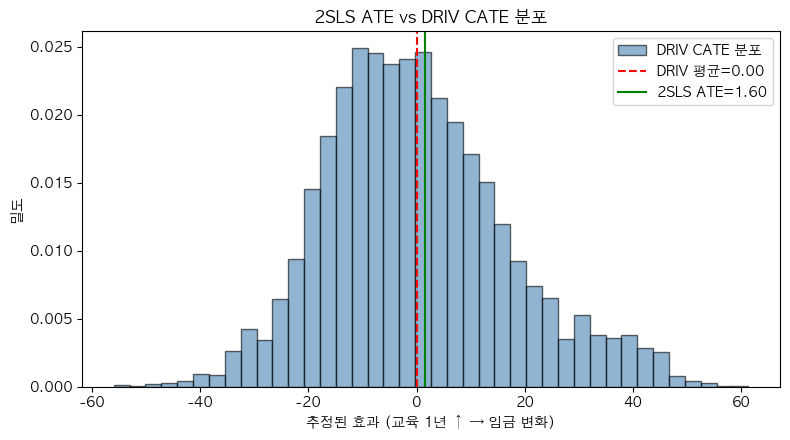

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 2SLS 추정치
iv_effect = iv_beta  # 앞에서 구한 1.6 정도

# DRIV 개별 효과 추정 (CATE)
driv_te = None
if driv_est is not None:
    try:
        driv_te = driv_est.effect(X_scaled)   # 조건부 효과
    except Exception:
        driv_te = np.full_like(T, np.nan)

# 분포 시각화
if driv_te is not None and not np.all(np.isnan(driv_te)):
    plt.figure(figsize=(8,4.5))
    plt.hist(driv_te, bins=40, alpha=0.6, color="steelblue", edgecolor="k", density=True, label="DRIV CATE 분포")
    plt.axvline(np.mean(driv_te), color="red", linestyle="--", label=f"DRIV 평균={np.mean(driv_te):.2f}")
    plt.axvline(iv_effect, color="green", linestyle="-", label=f"2SLS ATE={iv_effect:.2f}")
    plt.axhline(0, color="black", linewidth=0.7)
    plt.xlabel("추정된 효과 (교육 1년 ↑ → 임금 변화)")
    plt.ylabel("밀도")
    plt.title("2SLS ATE vs DRIV CATE 분포")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("DRIV 효과 추정 불가 (NaN)")


In [8]:
import pandas as pd

# 조건 변수 목록
group_vars = ["gender_male", "income_low", "fcollege_yes",
              "mcollege_yes", "urban_yes", "region_west"]

# 1) 긴 형태(long) 테이블 만들기
rows = []
for g in group_vars:
    means = cate_df.groupby(g)["CATE_DRIV"].mean()
    for val, est in means.items():
        rows.append({"Condition": g, "Level": bool(val), "Mean_CATE": float(est)})

summary_by_group_df = pd.DataFrame(rows)

# 2) 피벗(집계는 평균) — 인덱스 중복 대비해 pivot_table 사용
summary_pivot = pd.pivot_table(
    summary_by_group_df,
    index="Condition",
    columns="Level",          # False/True
    values="Mean_CATE",
    aggfunc="mean"
).rename(columns={False: "False", True: "True"}).reset_index()

# 3) 보기 좋게 반올림
summary_by_group_df_rounded = summary_by_group_df.copy()
summary_by_group_df_rounded["Mean_CATE"] = summary_by_group_df_rounded["Mean_CATE"].round(6)

summary_pivot_rounded = summary_pivot.copy()
if "False" in summary_pivot_rounded:
    summary_pivot_rounded["False"] = summary_pivot_rounded["False"].round(6)
if "True" in summary_pivot_rounded:
    summary_pivot_rounded["True"] = summary_pivot_rounded["True"].round(6)

# # 4) 출력
# print("\n[조건별 CATE (long)]")
# print(summary_by_group_df_rounded.sort_values(["Condition","Level"]).to_string(index=False))

print("\n[조건별 CATE (wide/pivot)]")
print(summary_pivot_rounded.to_string(index=False))



[조건별 CATE (wide/pivot)]
   Condition     False      True
fcollege_yes  0.346783 -1.319954
 gender_male  1.611736 -1.959100
  income_low -6.711434  2.715207
mcollege_yes -0.541890  3.402835
 region_west -0.779173  3.136524
   urban_yes  1.065127 -3.507008


전역적으로(ATE) DRIV 평균은 0 근처였지만,

조건별로 보면 효과가 크게 갈린다는 게 포인트입니다.

저소득층, 여성, 서부 지역, 어머니 대학 졸업 → 교육이 임금에 양의 효과

남성, 중·고소득층, 도시, 부모 대학 졸업(특히 아버지) → 교육 효과가 약하거나 음수

따라서 DRIV은 "교육이 임금에 미치는 효과가 평균적으로는 0이지만, 누구에게는 크고 누구에게는 작다"는 이질성을 보여줌

-----------참고------------------
- education	최종 학력 (교육 연수)
- wage	임금 (시간당)
- distance	거주지에서 가장 가까운 4년제 대학까지의 거리 (10마일 단위)
- gender	성별 (예: female, male)
- ethnicity	인종 (예: afam, hisp, other)
- score	고등학교 재학 중 치른 종합 시험 점수
- fcollege	아버지가 대학 졸업자인지 여부 (factor)
- mcollege	어머니가 대학 졸업자인지 여부 (factor)
- home	자가 거주 여부 (factor)
- urban	학교가 도시에 위치하는지 여부 (factor)
- unemp	1980년 기준 거주 카운티의 실업률
- tuition	주(state)의 평균 4년제 대학 등록금 (1000달러 단위)
- income	가구 소득이 $25,000를 초과하는지 여부 (factor)
- region	거주 지역 (예: west, other)